# Unsupervised Learning and Anomaly Detection

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import os.path
import subprocess
import matplotlib.collections
import scipy.signal
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')

In [5]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(tf.__version__)

2.12.0


Helpers for Getting, Loading and Locating Data

In [6]:
def wget_data(url: str):
    local_path = './tmp_data'
    p = subprocess.Popen(["wget", "-nc", "-P", local_path, url], stderr=subprocess.PIPE, encoding='UTF-8')
    rc = None
    while rc is None:
      line = p.stderr.readline().strip('\n')
      if len(line) > 0:
        print(line)
      rc = p.poll()

def locate_data(name, check_exists=True):
    local_path='./tmp_data'
    path = os.path.join(local_path, name)
    if check_exists and not os.path.exists(path):
        raise RuxntimeError('No such data file: {}'.format(path))
    return path

## <span style="color:Orange">Get Data</span>

In [7]:
wget_data('https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/data/spectra_data.hf5')

--2024-04-11 11:22:10--  https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/data/spectra_data.hf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414744 (405K) [application/octet-stream]
Saving to: ‘./tmp_data/spectra_data.hf5’
     0K .......... .......... .......... .......... .......... 12% 5.00M 0s
    50K .......... .......... .......... .......... .......... 24% 9.92M 0s
   100K .......... .......... .......... .......... .......... 37% 8.21M 0s
   150K .......... .......... .......... .......... .......... 49% 11.4M 0s
   200K .......... .......... .......... .......... .......... 61% 18.7M 0s
   250K .......... .......... .......... .......... .......... 74% 16.7M 0s
   300K .......... .......... .......... .......... .....

# <span style="color:Orange">Networks for Unsupervised Learning</span>

Neural networks are usually used for supervised learning since their learning is accomplished by optimizing a loss function that compares the network's outputs with some target values. However, it is possible to perform unsupervised learning if we can somehow use the same data for both the input values and the target output values. This requires that the network have the same number of input and output nodes, and effectively means that we are asking it to learn the identify function, which does not sound obviously useful.

Suppose we have a single hidden layer with the same number of nodes as the input and output layers, then all the network has to do is pass each input value through to the output, which does not require any training at all!  However, if the hidden layer has fewer nodes then we are asking the network to solve a more interesting problem: how can the input dataset be encoded and then decoded. This is the same <span style="color:Violet">dimensionality reduction</span> problem we discussed [earlier](Dimensionality.ipynb), and is known as an <span style="color:Violet">autoencoder network</span> since it learns to encode itself:

<img src="https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/img/UnsupervisedLearning-AutoEncoder.png" width=400 align=left></img><br>

The network can be thought of as the combination of separate encoder and decoder networks, with the encoder feeding its output latent variables $\mathbf{z}$ into the decoder. Although the architecture looks symmetric, the encoder and decoder will generally learn different parameters because of the asymmetry introduced by nonlinear activations. The figure represents a high-level design pattern and the internal architectures of the encoder and decoder networks should be customized for the type of data being encoded (and typically combined convolutional and dense layers).

See this [blog post](http://kvfrans.com/variational-autoencoders-explained/) for an example based on decoding handwritten digits.

## <span style="color:LightGreen">Autoencoder Example</span>

Re-use the spectral data for an example. Recall that there are only 200 samples in 500 dimensions:

In [8]:
X = pd.read_hdf(locate_data('spectra_data.hf5')).values

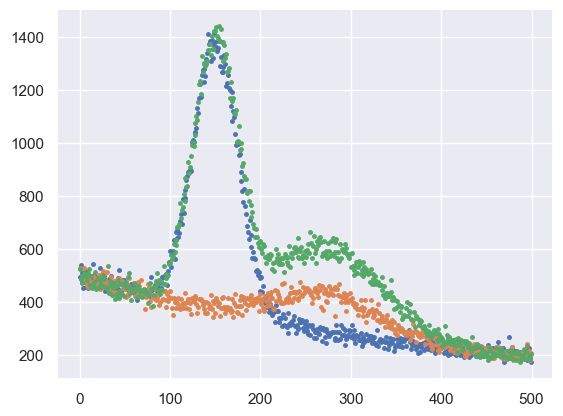

In [9]:
for i in (0, 6, 7):
    plt.plot(X[i], '.', ms=5)

The tensorflow layers API initializes parameters assuming that inputs are roughly normalized:

In [10]:
X0 = np.mean(X, axis=0)
Xmax = np.max(np.abs(X - X0))
Xn = (X - X0) / Xmax
original = lambda x: Xmax * x + X0
assert np.allclose(X, original(Xn))

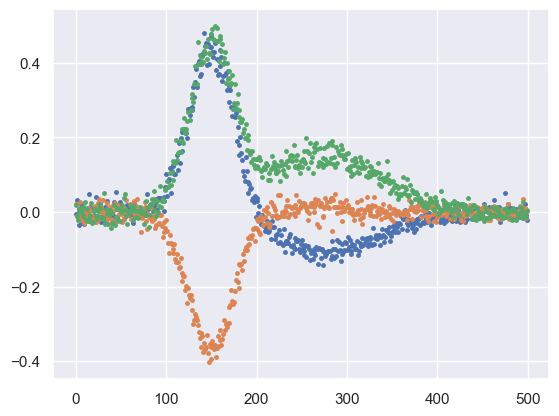

In [11]:
for i in (0, 6, 7):
    plt.plot(Xn[i], '.', ms=5)

Tensorflow does not provide a premade autoencoder so we build a custom estimator using the intermediate-level layers API:

In [13]:
def autoencoder_model(features, labels, mode, params):
    """Build a graph to TRAIN/TEST/PREDICT an autoencoder model.
    """
    D = params['dimension']
    C = params['n_components']
    eta = params['learning_rate']

    # Build the input layer.
    inputs = tf.reshape(features['X'], [-1, D])

    # Add encoder hidden layers with softsign activations.
    encoded = inputs
    for units in params['hidden_units']:
        encoded = tf.layers.dense(inputs=encoded, units=units, activation=tf.nn.softsign)

    # Add the final encoder layer with linear activation.
    latent = tf.layers.dense(inputs=encoded, units=C, activation=None)

    # Add decoder hidden layers with softsign activations.
    decoded = latent
    for units in params['hidden_units'][::-1]:
        decoded = tf.layers.dense(inputs=decoded, units=units, activation=tf.nn.softsign)

    # The final decoder layer has linear activation.
    outputs = tf.layers.dense(inputs=decoded, units=D, activation=None)

    # Return predicted labels and probabilities in PREDICT mode.
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions={
            'latent': latent, 'output': outputs})

    # Calculate the loss for TRAIN and EVAL modes.
    loss = tf.nn.l2_loss(outputs - inputs)

    # Compute evaluation metrics.
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss)

    # Create optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=eta)
    step = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=step)

The subsequent steps are similar to the previous examples:

In [14]:
tf.logging.set_verbosity(tf.logging.WARN)

In [15]:
!rm -rf tfs/autoenc

In [16]:
config = tf.estimator.RunConfig(
    model_dir='tfs/autoenc',
    tf_random_seed=123
)

Instructions for updating:
Use tf.keras instead.


In [17]:
autoenc = tf.estimator.Estimator(
    config=config,
    model_fn=autoencoder_model,
    params = dict(
        dimension=500,
        hidden_units=[4],
        n_components=2,
        learning_rate=0.01))

Instructions for updating:
Use tf.keras instead.


In [18]:
autoenc.train(
    input_fn=tf.estimator.inputs.numpy_input_fn(
        x={'X': Xn}, y=None,
        batch_size=200, num_epochs=None, shuffle=True),
    steps=1000);


Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


2024-04-11 11:28:24.833603: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): CANCELLED: Enqueue operation was cancelled
	 [[{{node enqueue_input/random_shuffle_queue_EnqueueMany}}]]
2024-04-11 11:28:24.855059: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): CANCELLED: Queue '_0_enqueue_input/random_shuffle_queue' is already closed.
	 [[{{node enqueue_input/random_shuffle_queue_Close}}]]


Instructions for updating:
Use tf.keras instead.


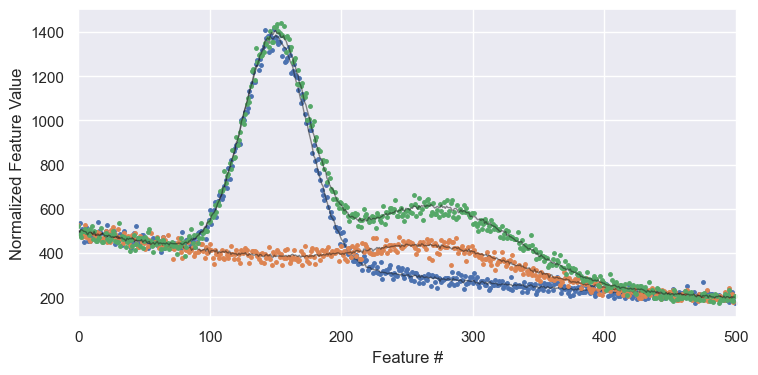

In [19]:
def plot_reconstructed(Xn, model):
    predictions = model.predict(
        input_fn=tf.estimator.inputs.numpy_input_fn(
            x={'X': Xn}, y=None, num_epochs=1, shuffle=False))
    N, D = Xn.shape
    fig = plt.figure(figsize=(8.5, 4))
    for i, pred in enumerate(predictions):
        Xr = original(pred['output'])
        plt.plot(original(Xn[i]), '.', ms=5)
        plt.plot(Xr, 'k-', lw=1, alpha=0.5)
    plt.xlim(-0.5, D+0.5)
    plt.xlabel('Feature #')
    plt.ylabel('Normalized Feature Value')

plot_reconstructed(Xn[[0, 6, 7]], model=autoenc)

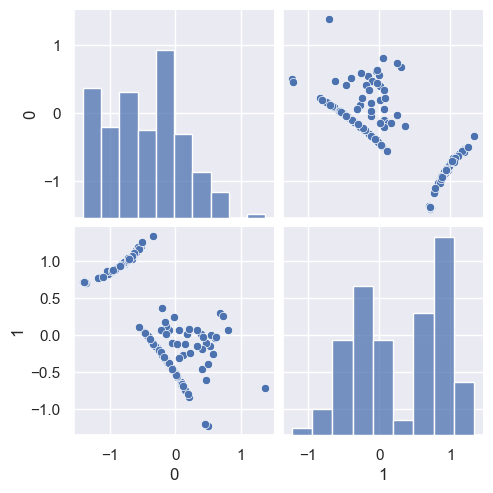

In [20]:
def plot_latent(Xn, model):
    predictions = model.predict(
        input_fn=tf.estimator.inputs.numpy_input_fn(
            x={'X': Xn}, y=None, num_epochs=1, shuffle=False))
    latent = []
    for pred in predictions:
        latent.append(pred['latent'])
    df = pd.DataFrame(latent)
    sns.pairplot(df)
    return df

latent = plot_latent(Xn, model=autoenc)

## <span style="color:LightGreen">Variational Autoencoder</span>

A further refinement on the autoencoder idea is to learn a posterior probability distribution in the latent variable space, instead of simply mapping each input to its corresponding point in the latent variable space. This is easier than it sounds if we assume that the posterior for each individual sample is described by an (uncorrelated) multi-variate Gaussian.

In practice, we simply need to learn how to transform each input to a corresponding vector of means $\mathbf{\mu}$ and sigmas $\mathbf{\sigma}$ in the latent variable space, effectively doubling the the number of output values for the encoder network, now re-interpreted as a posterior inference network. Since this first stage is effectively a variational model of the posterior, learning its parameters is equivalent to performing a variational inference and we call this approach a <span style="color:Violet">variational autoencoder</span> (VAE).

The decoder network is also re-interpreted as a probabilistic generator of realistic (smoothed) data. It is a generator rather than a decoder since it is no longer directly connected to the inputs. After training, it can be useful as a standalone simulator of realistic inputs.

Finally we need a prior which we take to be a unit (multivariate) Gaussian in the latent-variable space.  This is an arbitrary choice, but some choice is necessary in order to setup the balance between the influence of each input against some prior that is a key feature of Bayesian learning. In effect, we are reversing the way we usually build a model, which is to specify the parameters then ask what their prior should be.  Instead, we are specifying the prior and then learning a (latent) parameter space that can explain the data with this prior:

<img src="https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/img/UnsupervisedLearning-VariationalAutoEncoder.png" width=400 align=left></img><br>

In a bit more detail, the upper network implements a variational model $Q(z;X,\Theta)$ for the posterior probability density $P(X\mid z)$ of a single sample $X$, parameterized by its weights and biases in $\Theta$. Specifically, $Q$ is a multivariate Gaussian in $z$ with parameters $\mu_z(X, \Theta)$ and $\sigma_z(X, \Theta)$ output by the upper network.

The lower network generates $X$ from $z$ and the the part of the loss function that compares its output against the input plays the role of the negative-log likelihood $-\log P(X\mid z)$ of a single sample $X$.

Recall that in variational inference, we minimize the negative <span style="color:Violet">evidence lower bound</span> (ELBO):

$$ \Large
-\int d z\, Q(z; X,\Theta) \log P(X\mid z) + \text{KL}(Q\parallel P)
= \langle -\log P(X\mid z)\rangle_{z\sim Q}  + \text{KL}(Q\parallel P)
\; ,
$$

where $P$ is the prior on $z$. Since both $Q$ and $P$ are (multivariate) Gaussians, we can evaluate their KL divergence analytically, as

$$ \Large
\text{KL}(Q\parallel P) = \frac{1}{2} \sum_{i=1}^C\,
\left[ \mu_{z,i}^2 + \sigma_{z,i}^2 - \log \sigma_{z,i}^2 - 1 \right]
$$

where $C$ is the dimension of the latent space. 

Therefore, the total loss function we want to optimize combines the likelihood, which compares the input with the generated output, and a KL divergence term.  If we assume that the data samples have Gaussian homoscedastic noise with variance $\sigma_x^2$, then the first term in the negative ELBO is

$$ \Large
-\log P(X\mid z) = \frac{1}{2\sigma_x^2} \left| \mathbf{X}_{out} - \mathbf{X}_{in}\right|^2 + \text{constant} \; .
$$

Note that is almost the $L_2$ loss, but since we are combining it with the KL term, we must keep track of the $\sigma_x^{-2}$ scaling. With this choice of noise model, $\sigma_x$ is a hyperparameter but other noise models (e.g., Poisson errors) would not need any hyperparameter. After normalization, the uncertainties in this dataset correspond to $\sigma_x \simeq 0.017$.

Finally, training the overall network accomplishes two goals in parallel:
 - Find a latent space where a unit Gaussian prior can explain the training data.
 - Perform variational inference to find the best $Q(z; X, \Theta)$ that approximates the posteriors $P(z\mid X)$ for each training sample.

See this [tutorial](https://arxiv.org/abs/1606.05908) for more details on the probabilistic background of VAE.

Our custom estimator to implement a VAE shares most of its code with the earlier autoencoder:

In [21]:
def variational_autoencoder_model(features, labels, mode, params):
    """Build a graph to TRAIN/TEST/PREDICT a variational autoencoder model.
    """
    D = params['dimension']
    C = params['n_components']
    eta = params['learning_rate']
    sigx = params['noise_sigma']

    # Build the input layer
    inputs = tf.reshape(features['X'], [-1, D])

    # Add encoder hidden layers with softsign activations
    encoded = inputs
    for units in params['hidden_units']:
        encoded = tf.layers.dense(inputs=encoded, units=units, activation=tf.nn.softsign)

    # Add the final encoder layer with linear activation
    # Estimate the posterior mean and t=log(sigma) in the latent space
    latent_mu = tf.layers.dense(inputs=encoded, units=C, activation=None)
    latent_t = tf.layers.dense(inputs=encoded, units=C, activation=None)

    # Draw random samples from the encoded posterior
    sigma = tf.exp(latent_t)
    latent = latent_mu + sigma * tf.random_normal(tf.shape(sigma))

    # Add decoder hidden layers with softsign activations
    decoded = latent
    for units in params['hidden_units'][::-1]:
        decoded = tf.layers.dense(inputs=decoded, units=units, activation=tf.nn.softsign)

    # The final decoder layer has linear activation
    outputs = tf.layers.dense(inputs=decoded, units=D, activation=None)

    # Return predicted labels and probabilities in PREDICT mode
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions={
            'mean': latent_mu,
            'sigma': sigma,
            'latent': latent,
            'output': outputs})

    # Calculate the loss for TRAIN and EVAL modes.
    decoder_loss = tf.reduce_sum((outputs - inputs) ** 2, axis=1) / (2 * sigx)
    kl_loss = 0.5 * tf.reduce_sum(latent_mu ** 2 + sigma ** 2 - 2 * latent_t - 1, axis=1)
    loss = tf.reduce_mean(decoder_loss + kl_loss)

    # Compute evaluation metrics.
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss)

    # Create optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=eta)
    step = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=step)

In [22]:
tf.logging.set_verbosity(tf.logging.WARN)

In [23]:
!rm -rf tfs/vae

In [24]:
config = tf.estimator.RunConfig(
    model_dir='tfs/vae',
    tf_random_seed=123
)

In [25]:
vae = tf.estimator.Estimator(
    config=config,
    model_fn=variational_autoencoder_model,
    params = dict(
        dimension=500,
        hidden_units=[],
        n_components=2,
        noise_sigma=0.015,
        learning_rate=0.001))

In [26]:
vae.train(
    input_fn=tf.estimator.inputs.numpy_input_fn(
        x={'X': Xn}, y=None,
        batch_size=250, num_epochs=None, shuffle=True),
    steps=10000);

2024-04-11 11:38:02.436742: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): CANCELLED: Enqueue operation was cancelled
	 [[{{node enqueue_input/random_shuffle_queue_EnqueueMany}}]]
2024-04-11 11:38:02.455948: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): CANCELLED: Queue '_3_enqueue_input/random_shuffle_queue' is already closed.
	 [[{{node enqueue_input/random_shuffle_queue_Close}}]]


The plots below summarize the trained network's predictions. The left plot shows random samples drawn from the posteriors of individual samples and the right plot shows the distribution of the training data in the latent space. A few samples are highlighted in red in both plots: ellipses in the right-hand plot show each sample's posterior compared with the prior (dotted red circle).

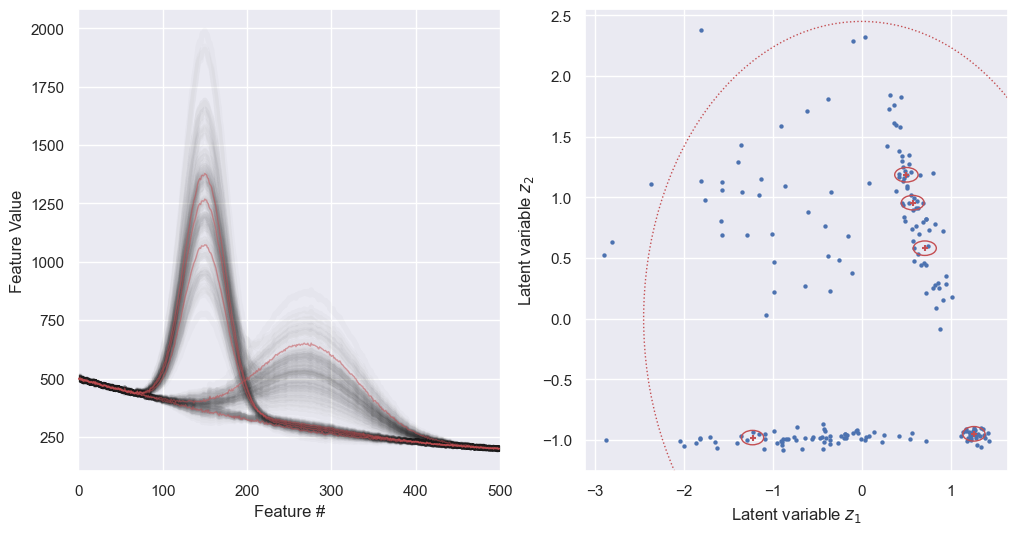

In [27]:
def plot_predicted(Xn, model=vae, nsamples=5, nsig=2.45):
    predictions = model.predict(
        input_fn=tf.estimator.inputs.numpy_input_fn(
            x={'X': Xn}, y=None, num_epochs=1, shuffle=False))
    N, D = Xn.shape
    mean, sigma, z = [], [], []
    _, ax = plt.subplots(1, 2, figsize=(12, 6))
    for i, pred in enumerate(predictions):
        Xr = original(pred['output'])
        if i < nsamples:
            ax[0].plot(Xr, 'r-', lw=1, alpha=0.5, zorder=10)
        else:
            ax[0].plot(Xr, 'k-', lw=4, alpha=0.02)
        mean.append(pred['mean'])
        sigma.append(pred['sigma'])
        z.append(pred['latent'])
    ax[0].set_xlim(-0.5, D+0.5)
    ax[0].set_xlabel('Feature #')
    ax[0].set_ylabel('Feature Value')
    mean = np.array(mean)
    sigma = np.array(sigma)
    z  = np.array(z)
    ax[1].scatter(z[:, 0], z[:, 1], s=10, lw=0)
    ax[1].add_artist(plt.Circle([0,0], nsig, ls=':', fc='none', ec='r', lw=1))
    mu = mean[:nsamples]
    ax[1].scatter(mu[:, 0], mu[:, 1], s=25, marker='+', color='r')
    widths = nsig * sigma[:nsamples, 0]
    heights = nsig * sigma[:nsamples, 1]
    angles = np.zeros_like(widths)
    ax[1].add_collection(matplotlib.collections.EllipseCollection(
        widths, heights, angles, units='xy', offsets=mu, linewidths=1,
        transOffset=ax[1].transData, facecolors='none', edgecolors='r'))
    ax[1].set_xlabel('Latent variable $z_1$')
    ax[1].set_ylabel('Latent variable $z_2$')

plot_predicted(Xn)

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer

© Copyright 2024